In [267]:
# Importando os dados do arquivo csv

import pandas as pd

df_tweet = pd.read_csv('Dados/train/Train3classes.csv')

print(df_tweet.shape)

df_tweet.sample(10).head()

(95000, 5)


,id,tweet_text,tweet_date,sentiment,query_used
70078,1045435831169757185,Matéria legal da UOL sobre nosso trampo diário...,Thu Sep 27 22:11:40 +0000 2018,1,:)
44782,1047868099993751552,"Em clima de tensão, Cruzeiro busca virada cont...",Thu Oct 04 15:16:38 +0000 2018,2,veja
43729,1046948582606168064,td q eu queria hoje era q a amelie tivesse aqu...,Tue Oct 02 02:22:48 +0000 2018,0,:(
45805,1049112622518456320,No meu wpp e no meu tt só tem gente reclamando...,Mon Oct 08 01:41:55 +0000 2018,1,:)
7747,1045500224574246913,@aninhamirandams Obrigado :),Fri Sep 28 02:27:32 +0000 2018,1,:)


In [268]:
from sklearn.model_selection import train_test_split

In [269]:
# Separando o Dataframe em Dataframe de Treino e de Teste

df_experiment, df_test = train_test_split(df_tweet, test_size=.3)

In [270]:
SUBSET_DUPLICADOS = df_experiment.drop(['tweet_date', 'id'], axis=1).columns.to_list()

num_duplicados = df_experiment.duplicated(subset=SUBSET_DUPLICADOS).sum()

print(f'{num_duplicados} linhas duplicadas em {len(df_experiment)} registros')

432 linhas duplicadas em 66500 registros


In [271]:
df_experiment = df_experiment.drop_duplicates(subset=SUBSET_DUPLICADOS)

print(df_experiment.shape, f'{df_experiment.duplicated(subset=SUBSET_DUPLICADOS).sum()}')

(66068, 5) 0


<AxesSubplot:>

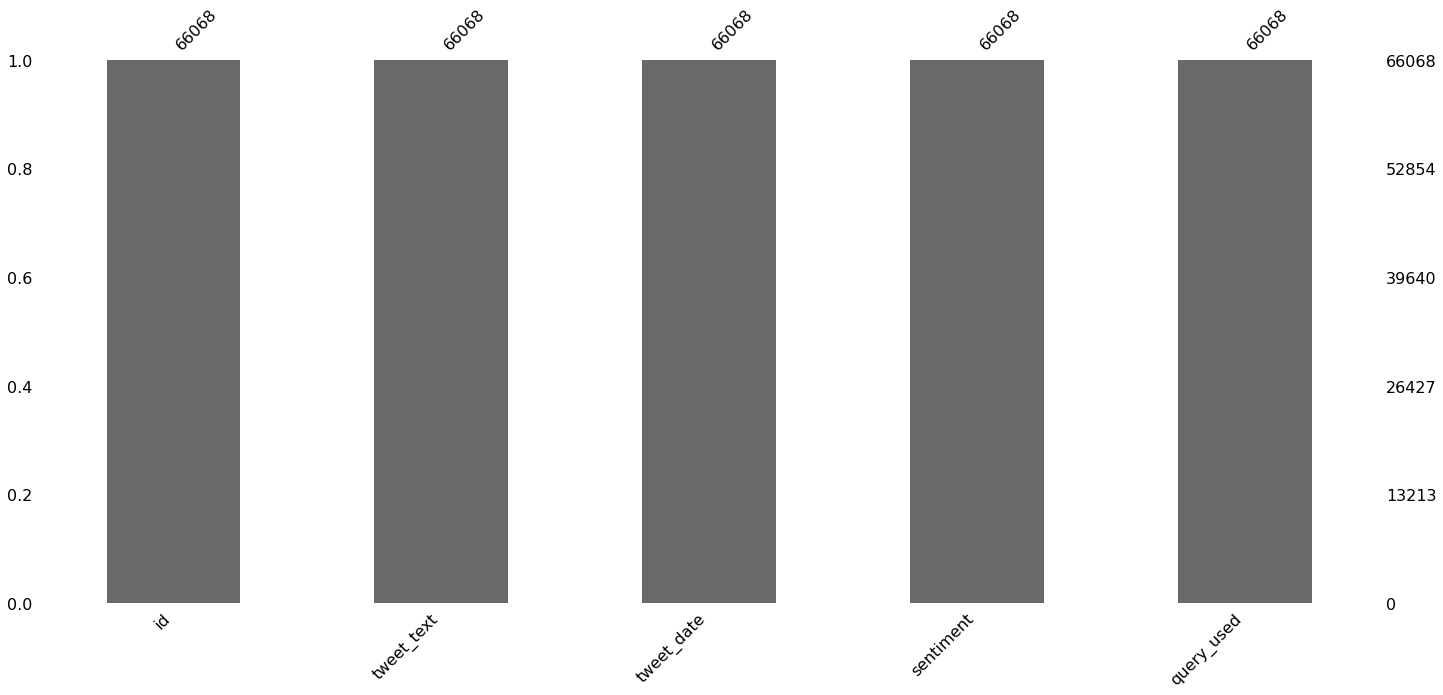

In [272]:
import missingno as msno
msno.bar(df_experiment)

In [273]:
#df_experiment[['tweet_text', 'sentiment']].drop_duplicates()

In [274]:
import re

def clean_https(df):
    text = df['tweet_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0]);
    
    return text

In [275]:
clean_https(df_experiment)

47335    Gosta de la la land? — nao :( é um dos únicos ...
71210    &gt;@EstadaoEconomia Família corta compra para...
7340     Salado. :D #SuperJunior #PCAs #TheGroup @SJoff...
60250                            to c uma sdd da Ariele :(
19198    Ibope Senado - Pernambuco, votos válidos: Jarb...
                               ...                        
8212       @PandinhaGame Bom dia, bonequinho de papelão :P
42954    o Brasil não te merece, Ciro :( felizmente pre...
4982     @mfilipa11 @mpereira43 @FilipaVieiraSi1 @catar...
74618    Globo exibirá primeiro capítulo da série 'Assé...
1763     &gt;@Emais_Estadao 'Espero que a gente consiga...
Name: tweet_text, Length: 66068, dtype: object

In [276]:
df_experiment.sample(10).head()

,id,tweet_text,tweet_date,sentiment,query_used
69663,1048204939145744384,Essa sexta vai ficar sem vídeo por motivos de ...,Fri Oct 05 13:35:06 +0000 2018,1,:)
53607,1038296383101579264,Campanha de Bolsonaro monitora reação da inter...,Sat Sep 08 05:22:03 +0000 2018,2,folha
85692,1049289246610247680,@guigonzalez98 @nathmariz_ @dudunogueira00 Abr...,Mon Oct 08 13:23:45 +0000 2018,1,:)
11992,1049257529744789509,"@laurjsaturnn menos não, é a verdade :)",Mon Oct 08 11:17:44 +0000 2018,1,:)
1856,1049136082590347271,@faz_porque @Gregorio92matos @MadameBoco @FPun...,Mon Oct 08 03:15:08 +0000 2018,0,:(


In [277]:
df_train, df_valid = train_test_split(df_experiment, test_size=.2)

In [278]:
x_train, y_train = df_train['tweet_text'], df_train['sentiment']
x_valid, y_valid = df_valid['tweet_text'], df_valid['sentiment']

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(52854,) (52854,)
(13214,) (13214,)


In [279]:
# Utilizando o Word2Vec

from gensim.utils import simple_preprocess

# Vamos chamar essa função sempre que quisermos quebrar um texto em palavras
def tokenize(text):
    return simple_preprocess(text, min_len=1)

from tqdm import tqdm
import numpy as np

def to_word_vector(words, w2v):

    vectors = []

    for word in words:
        vectors.append(w2v.wv[word] if word in w2v.wv.key_to_index else np.zeros(w2v.vector_size))
        
    if not vectors:
        vectors.append(np.zeros(w2v.vector_size))
    
    return np.mean(vectors, axis=0).astype('float16')

def embeddings(x, w2v):
    x = x.copy()

    x = x.apply(tokenize)

    x = np.vstack([[to_word_vector(sentences, w2v)] for sentences in tqdm(x)])

    return x

In [280]:
from gensim.models import Word2Vec

model_w2v = Word2Vec(
        sentences=x_train.apply(
            lambda t: tokenize(t)
        ),
         vector_size=300,
         window=5,
         min_count=1,
         workers=4
    )

In [281]:
x_train_transformed = embeddings(x_train, model_w2v)

x_valid_transformed = embeddings(x_valid, model_w2v)

100%|██████████| 13214/13214 [00:01<00:00, 7846.38it/s]


In [282]:
from lightgbm import LGBMClassifier

In [283]:
#from sklearn.model_selection import GridSearchCV

#modelo = LGBMClassifier()

#parameters = {
#    'max_depth': [3, 4, 5],
#    'n_estimators': [20, 50, 70],
#    'learning_rate': [0.01, 0.1, 0.5],
#    'num_leaves': [10, 20, 30],
#    'is_unbalance': [True, False]
#}

#clf = GridSearchCV(modelo, parameters, verbose=3, scoring='f1_macro', cv=3)

#clf.fit(x_train_transformed, y_train)

In [284]:
#clf.best_params_

In [285]:
#modelo = LGBMClassifier(**clf.best_params_)

In [286]:
modelo = LGBMClassifier(n_estimators=70, max_depth=4, num_leaves=20, 
                        is_unbalance=True, learning_rate=0.5)

In [287]:
modelo.fit(x_train_transformed, y_train)

LGBMClassifier(is_unbalance=True, learning_rate=0.5, max_depth=4,
               n_estimators=70, num_leaves=20)

In [288]:
y_train_pred = modelo.predict(x_train_transformed)

y_valid_pred = modelo.predict(x_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(52854,) (13214,)


In [247]:
#modelo = LGBMClassifier(n_estimators=70, max_depth=5, num_leaves=20, 
#                        is_unbalance=True, learning_rate=0.5)

In [248]:
#modelo.fit(x_train_transformed, y_train)

In [249]:
#modelo.fit(x_train_transformed, x_train)

In [250]:
#y_train_pred = modelo.predict(x_train_transformed)

#y_valid_pred = modelo.predict(x_valid_transformed)

#print(y_train_pred.shape, y_valid_pred.shape)

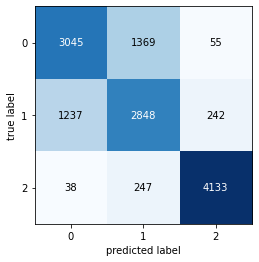

In [289]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

cm = confusion_matrix(y_valid, y_valid_pred)

plot_confusion_matrix(conf_mat=cm)
plt.show()

In [290]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

acc_train = accuracy_score(y_train, y_train_pred)
prec_train = precision_score(y_train, y_train_pred,average='micro')
rec_train = recall_score(y_train, y_train_pred, average='micro')

acc_valid = accuracy_score(y_valid, y_valid_pred)
prec_valid = precision_score(y_valid, y_valid_pred, average='micro')
rec_valid = recall_score(y_valid, y_valid_pred, average='micro')

print(f'Treino:\nAcc: {acc_train:.2f}, Precision: {prec_train:.2f}, Recall: {rec_train:.2f}')
print(f'Validação:\nAcc: {acc_valid:.2f}, Precision: {prec_valid:.2f}, Recall: {rec_valid:.2f}')

Treino:
Acc: 0.85, Precision: 0.85, Recall: 0.85
Validação:
Acc: 0.76, Precision: 0.76, Recall: 0.76


## Random Forest

In [253]:
from sklearn.ensemble import RandomForestClassifier

In [69]:
#from sklearn.model_selection import GridSearchCV

#modelo = RandomForestClassifier()

#parameters = {
#    'max_depth': [3, 4, 5],
#    'n_estimators': [20, 50, 70],
#    'random_state': [10, 12, 15],
#}

#clf = GridSearchCV(modelo, parameters, verbose=3, scoring='f1_macro', cv=3)

#clf.fit(x_train_transformed, y_train)

In [70]:
#clf.best_params_

In [71]:
#modelo = RandomForestClassifier(**clf.best_params_)

In [254]:
modelo = RandomForestClassifier(max_depth=5, n_estimators=70, random_state=12)

In [257]:
modelo.fit(x_train_transformed, y_train)

RandomForestClassifier(max_depth=5, n_estimators=70, random_state=12)

In [258]:
y_train_pred = modelo.predict(x_train_transformed)

y_valid_pred = modelo.predict(x_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(52818,) (13205,)


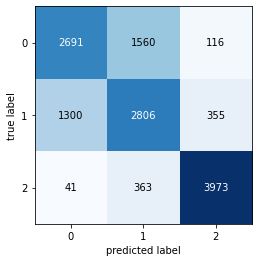

In [259]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

cm = confusion_matrix(y_valid, y_valid_pred)

plot_confusion_matrix(conf_mat=cm)
plt.show()

In [260]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

acc_train = accuracy_score(y_train, y_train_pred)
prec_train = precision_score(y_train, y_train_pred,average='micro')
rec_train = recall_score(y_train, y_train_pred, average='micro')

acc_valid = accuracy_score(y_valid, y_valid_pred)
prec_valid = precision_score(y_valid, y_valid_pred, average='micro')
rec_valid = recall_score(y_valid, y_valid_pred, average='micro')

print(f'Treino:\nAcc: {acc_train:.2f}, Precision: {prec_train:.2f}, Recall: {rec_train:.2f}')
print(f'Validação:\nAcc: {acc_valid:.2f}, Precision: {prec_valid:.2f}, Recall: {rec_valid:.2f}')

Treino:
Acc: 0.72, Precision: 0.73, Recall: 0.72
Validação:
Acc: 0.72, Precision: 0.72, Recall: 0.72


## AdaBoost

In [261]:
from sklearn.ensemble import AdaBoostClassifier

In [262]:
modelo = AdaBoostClassifier(n_estimators=20, random_state=12)

modelo

AdaBoostClassifier(n_estimators=20, random_state=12)

In [263]:
modelo.fit(x_train_transformed, y_train)

AdaBoostClassifier(n_estimators=20, random_state=12)

In [264]:
y_train_pred = modelo.predict(x_train_transformed)

y_valid_pred = modelo.predict(x_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(52818,) (13205,)


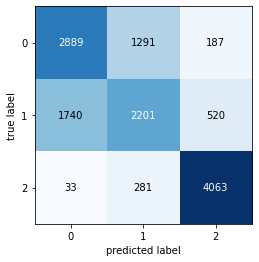

In [265]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

cm = confusion_matrix(y_valid, y_valid_pred)

plot_confusion_matrix(conf_mat=cm)
plt.show()

In [266]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

acc_train = accuracy_score(y_train, y_train_pred)
prec_train = precision_score(y_train, y_train_pred,average='micro')
rec_train = recall_score(y_train, y_train_pred, average='micro')

acc_valid = accuracy_score(y_valid, y_valid_pred)
prec_valid = precision_score(y_valid, y_valid_pred, average='micro')
rec_valid = recall_score(y_valid, y_valid_pred, average='micro')

print(f'Treino:\nAcc: {acc_train:.2f}, Precision: {prec_train:.2f}, Recall: {rec_train:.2f}')
print(f'Validação:\nAcc: {acc_valid:.2f}, Precision: {prec_valid:.2f}, Recall: {rec_valid:.2f}')

Treino:
Acc: 0.70, Precision: 0.70, Recall: 0.70
Validação:
Acc: 0.69, Precision: 0.68, Recall: 0.69


## Teste

In [291]:
x_test = df_test['tweet_text']
y_test = df_test['sentiment']

print(x_test.shape, y_test.shape)

(28500,) (28500,)


In [292]:
x_test_transformed = embeddings(x_test, model_w2v)

print(x_test_transformed.shape)

100%|██████████| 28500/28500 [00:03<00:00, 8764.58it/s] 


(28500, 300)


In [293]:
y_test_pred = modelo.predict(x_test_transformed)

print(y_test_pred.shape)

(28500,)


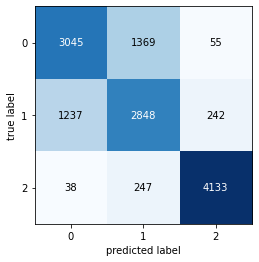

In [294]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

cm = confusion_matrix(y_valid, y_valid_pred)

plot_confusion_matrix(conf_mat=cm)
plt.show()

In [295]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

acc_test = accuracy_score(y_test, y_test_pred)
prec_test = precision_score(y_test, y_test_pred,average='micro')
rec_test = recall_score(y_test, y_test_pred, average='micro')


print(f'Teste:\nAcc: {acc_test:.2f}, Precision: {prec_test:.2f}, Recall: {rec_test:.2f}')

Teste:
Acc: 0.77, Precision: 0.77, Recall: 0.77


## Subm

In [296]:
df_subm = pd.read_csv('Dados/subm/Subm3classes.csv')

print(df_subm.shape)

df_subm.sample(10).head()

(5000, 4)


,id,tweet_text,tweet_date,query_used
3602,1049227466521436160,Queria estrear o meu bb novo Mas sei q vou suj...,Mon Oct 08 09:18:16 +0000 2018,:(
1107,1047510275526680578,nas quartas o brigadeiro usa rosa :) https://t...,Wed Oct 03 15:34:46 +0000 2018,:)
600,1049404063228588039,Celso Rocha de Barros | O PT que existiu até a...,Mon Oct 08 21:00:00 +0000 2018,folha
2458,1037054576090902528,Veja o que é #FATO ou #FAKE na entrevista de G...,Tue Sep 04 19:07:33 +0000 2018,#fato
3590,1047445160861347840,@_tauries @beatriz_seca ja vi um pouco dele e ...,Wed Oct 03 11:16:01 +0000 2018,:)


In [297]:
def sentimento(query):
    if query == ':)':
        return 1
    elif query == ':(':
        return 0
    else:
        return 2

In [298]:
df_subm['sentiment'] = df_subm['query_used'].apply(sentimento)

In [299]:
df_subm.sample(10).head()

,id,tweet_text,tweet_date,query_used,sentiment
677,1047548161278074880,Alex Atala é o sétimo melhor chef do mundo. Ve...,Wed Oct 03 18:05:18 +0000 2018,exame,2
1790,1045397504534155273,Por que vc tava triste hoje? Vc só anda assim ...,Thu Sep 27 19:39:22 +0000 2018,:),1
2668,1046963543713751041,@cryptidhao outro pecado :( deus tá vendo e ñ ...,Tue Oct 02 03:22:15 +0000 2018,:(,0
1982,1046225369207123968,criando coragem pra ver o último ep de tvd no ...,Sun Sep 30 02:29:00 +0000 2018,:(,0
3234,1042790488049254402,&gt;@EstadaoEconomia Trabalhadores passam ao d...,Thu Sep 20 15:00:01 +0000 2018,estadao,2


In [300]:
x_subm = df_subm['tweet_text']
y_subm = df_subm['sentiment']

print(x_subm.shape, y_subm.shape)

(5000,) (5000,)


In [301]:
x_subm_transformed = embeddings(x_subm, model_w2v)

print(x_subm_transformed.shape)

100%|██████████| 5000/5000 [00:00<00:00, 10723.31it/s]

(5000, 300)


In [302]:
y_subm_pred = modelo.predict(x_subm_transformed)

print(y_subm_pred.shape)

(5000,)


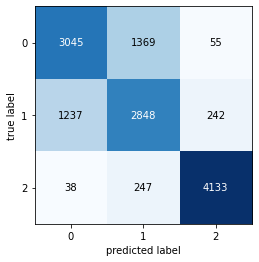

In [303]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

cm = confusion_matrix(y_valid, y_valid_pred)

plot_confusion_matrix(conf_mat=cm)
plt.show()

In [304]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

acc_subm = accuracy_score(y_subm, y_subm_pred)
prec_subm = precision_score(y_subm, y_subm_pred,average='micro')
rec_subm = recall_score(y_subm, y_subm_pred, average='micro')


print(f'Teste:\nAcc: {acc_test:.2f}, Precision: {prec_test:.2f}, Recall: {rec_test:.2f}')

Teste:
Acc: 0.77, Precision: 0.77, Recall: 0.77


In [ ]:
#from bs4 import BeautifulSoup
#import lxml.html

#def clean_tweet(text):
#    clean_text = BeautifulSoup(text, "lxml").text
    
#    return clean_text

In [ ]:
#df_experiment['tweet_text'] = df_experiment['tweet_text'].apply(clean_lxml);

In [ ]:
#import numpy as np
#import re

#def remove_pattern(text, pattern_regex):
#    r = re.findall(pattern_regex, text)
#    for i in r:
#        text = re.sub(i, '', text)
    
#    return text

In [ ]:
#df_experiment['tweet_text'] = np.vectorize(remove_pattern)(df_experiment['tweet_text'], "@[\w]*: | *RT*");